In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
from wgomoku import GomokuTools as gt, SampleDataHelper
from wgomoku import PolicyModel, display_sample, new_policy_dataset

In [5]:
N=19

In [6]:
model = PolicyModel(board_size=N, n_blocks=10, 
                    n_layers=3, n_filters=32, 
                    activation='relu')

In [7]:
sdh = SampleDataHelper(N, representation='NxNx1B', cut_off=12)
inputs = new_policy_dataset(file_pattern="*corr.csv", 
                     sdh=sdh, batch_size=512, num_epochs=1)    

W0804 06:25:28.945678 139799770048256 deprecation.py:323] From /home/wgiersche/workspace/DeepGomoku/tf2/lib/python3.5/site-packages/tensorflow/python/data/experimental/ops/readers.py:498: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
W0804 06:25:28.969330 139799770048256 deprecation.py:323] From /home/wgiersche/workspace/DeepGomoku/tf2/lib/python3.5/site-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python funct

In [8]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2), loss=loss)
#model.fit(inputs)

In [13]:
checkpoint_path = './models/PolicyNet_1.0/cp-{epoch:04d}.ckpt'
model.save_weights(checkpoint_path.format(epoch=6))

In [13]:
latest = tf.train.latest_checkpoint("./models/PolicyNet_1.0/")
print(latest)
new_model = PolicyModel(board_size=19, n_blocks=10, 
                    n_layers=3, n_filters=32, 
                    activation='relu')
new_model.load_weights(latest)
model = new_model

./models/PolicyNet_1.0/cp-0006.ckpt


---
# Using the policy results

In [14]:
import pandas as pd
import seaborn as sns
from wgomoku import analyse_and_recommend

In [15]:
game="j10i9i10k10j11j9k12h9k9l11m12h10h7h12h11j12g9g11f12k7j8i7l13m14l8m7k14j15o10n11k8i8m8n8j13i12k13m13k15k16k11"
game="j10i9i10k10j11j9k12h9k9l11m12h10h7h12h11j12g9g11f12k7j8i7l13m14l8m7k14j15o10n11k8i8m8n8j13i12k13"
stones = gt.string_to_stones(game)

In [16]:
smpnp = sdh.sample_from_string(game)
pi = new_model.dist(smpnp.reshape(1, 21, 21, 2)).numpy()

In [17]:
display_sample(smpnp)

[[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0 -1  0  1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0 -1  0  1  1  1 -1  0 -1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  1 -1  0 -1  0  1  0  1  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  1 -1 -1  1  0  0  0 -1  0  0  0  0  2]
 [ 2  0  0  0  0  0  0 -1  1  1  1 -1  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  1 -1 -1 -1 -1  1  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0 -1  1  0  1  0  1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0

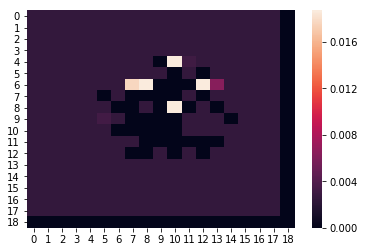

In [18]:
distr, greedy = analyse_and_recommend(smpnp, pi, 10)
sns.heatmap(distr)

In [19]:
greedy

[(array([11, 16]), 0.0025382875464856625),
 (array([11, 15]), 0.018709048628807068),
 (array([12, 15]), 0.003123064525425434),
 (array([ 8, 13]), 0.01774357631802559),
 (array([ 9, 13]), 0.018709048628807068),
 (array([13, 13]), 0.018709048628807068),
 (array([14, 13]), 0.006371547468006611),
 (array([ 6, 11]), 0.0025365352630615234),
 (array([11, 11]), 0.018709048628807068),
 (array([ 6, 10]), 0.0032520941458642483)]

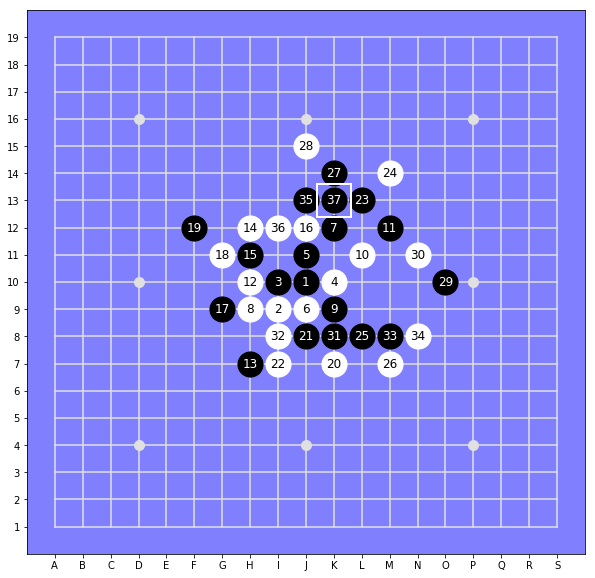

In [20]:
from wgomoku import GomokuBoard, Heuristics
board = GomokuBoard(N=19, heuristics=Heuristics(kappa=3.0), 
                    stones=stones, disp_width=10)
board.display()